In [2]:
%load_ext autoreload
%autoreload 2

from model_utils import load_model
from DisruptionPredictors import DisruptionPredictorSM, DisruptionPredictorRF, DisruptionPredictorKM
from Experiments import Experiment
from plot_experiments import *

device = 'cmod'
#dataset_path = 'no_ufo_flattop_1452_shots_50%_disruptive'
#dataset_path = 'random_flattop_256_shots_60%_disruptive'
dataset_path = 'no_ufo_flattop_7736_shots_6%_disruptive'

# Load models and create disruption predictors

cph_model, cph_features = load_model('cph', device, dataset_path)
cph_predictor = DisruptionPredictorSM("Cox Proportional Hazards", cph_model, cph_features)

#dcph_model, dcph_transformer, dcph_features = load_model('dcph', device, dataset_path)
#dcph_predictor = DisruptionPredictorSM("Deep Cox Proportional Hazards", dcph_model, dcph_features, dcph_transformer)

#dcm_model, dcm_transformer, dcm_features = load_model('dcm', device, dataset_path)
#dcm_predictor = DisruptionPredictorSM("Deep Cox Mixture", dcm_model, dcm_features, dcm_transformer)

dsm_model, dsm_features = load_model('dsm', device, dataset_path)
dsm_predictor = DisruptionPredictorSM("Deep Survival Machines", dsm_model, dsm_features)

#rsf_model, rsf_transformer, rsf_features = load_model('rsf', device, dataset)
#rsf_predictor = DisruptionPredictorSM("Random Survival Forest", rsf_model, rsf_features, rsf_transformer)

#dprf_model_50_ms, dprf_transformer, dprf_features = load_model('dprf_50_ms', device, dataset_path)
#dprf_predictor_50_ms = DisruptionPredictorRF("Random Forest", dprf_model_50_ms, dprf_features, dprf_transformer)

#dprf_model_100_ms, dprf_transformer, dprf_features = load_model('dprf_100_ms', device, dataset_path)
#dprf_predictor_100_ms = DisruptionPredictorRF("Random Forest", dprf_model_100_ms, dprf_features, dprf_transformer)

#dprf_model_150_ms, dprf_transformer, dprf_features = load_model('dprf_150_ms', device, dataset_path)
#dprf_predictor_150_ms = DisruptionPredictorRF("Random Forest", dprf_model_150_ms, dprf_features, dprf_transformer)

#dprf_model_400_ms, dprf_transformer, dprf_features = load_model('dprf_400_ms', device, dataset_path)
#dprf_predictor_400_ms = DisruptionPredictorRF("Random Forest", dprf_model_400_ms, dprf_features, dprf_transformer)



# Create experiments for each predictor
cph_experiment = Experiment(device, dataset_path, cph_predictor, 'CPH')
#dcph_experiment = Experiment(device, dataset_path, dcph_predictor, 'DCPH')
#dcm_experiment = Experiment(device, dataset_path, dcm_predictor, 'DCM')
dsm_experiment = Experiment(device, dataset_path, dsm_predictor, 'DSM')
#rsf_experiment = Experiment(device, test_dataset, rsf_predictor, 'RSF')
#dprf_experiment_50_ms = Experiment(device, dataset_path, dprf_predictor_50_ms, 'DPRF 50ms')
#dprf_experiment_100_ms = Experiment(device, dataset_path, dprf_predictor_100_ms, 'DPRF 100ms')
#dprf_experiment_150_ms = Experiment(device, dataset_path, dprf_predictor_150_ms, 'DPRF 150ms')
#dprf_experiment_400_ms = Experiment(device, dataset_path, dprf_predictor_400_ms, 'DPRF 400ms')

# Depending on which DPRF model is best
#dprf_experiment = Experiment(device, dataset_path, dprf_predictor_150_ms, 'DPRF')

#km_model, km_transformer, km_features = dprf_model_150_ms, dprf_transformer, dprf_features
#km_predictor = DisruptionPredictorKM("Kaplan-Meier", km_model, km_features, km_transformer)
#km_experiment = Experiment(device, dataset_path, km_predictor, 'KM')


Loaded model from models/cmod/no_ufo_flattop_7736_shots_6%_disruptive/cph.pkl
Loaded model from models/cmod/no_ufo_flattop_7736_shots_6%_disruptive/dsm.pkl


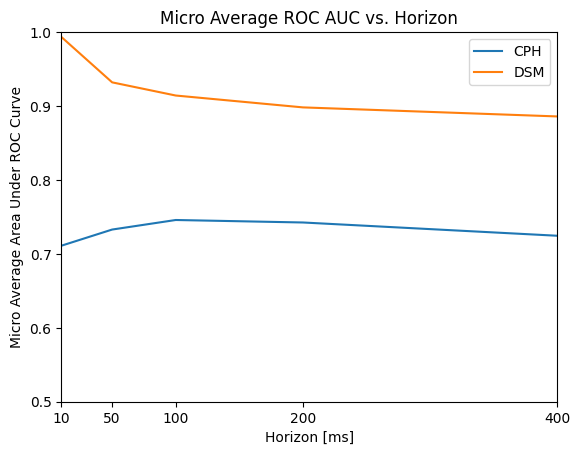

In [3]:
# Run the experiments
#core_experiment_list = [cph_experiment, dcph_experiment, dcm_experiment, dsm_experiment, dprf_experiment, km_experiment]
#core_experiment_list = [cph_experiment, dcph_experiment, dsm_experiment, dprf_experiment, km_experiment]

core_experiment_list = [cph_experiment, dsm_experiment]

#core_experiment_list = [dprf_experiment_50_ms, dprf_experiment_100_ms, dprf_experiment_150_ms, dprf_experiment_400_ms]

plot_roc_auc_vs_horizon_micro(core_experiment_list)

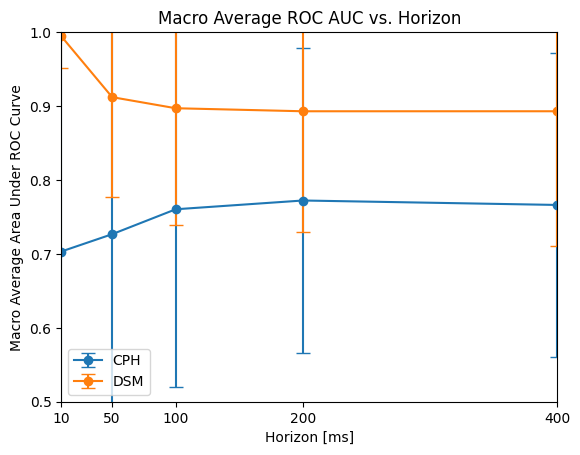

In [4]:
plot_roc_auc_vs_horizon_macro(core_experiment_list)

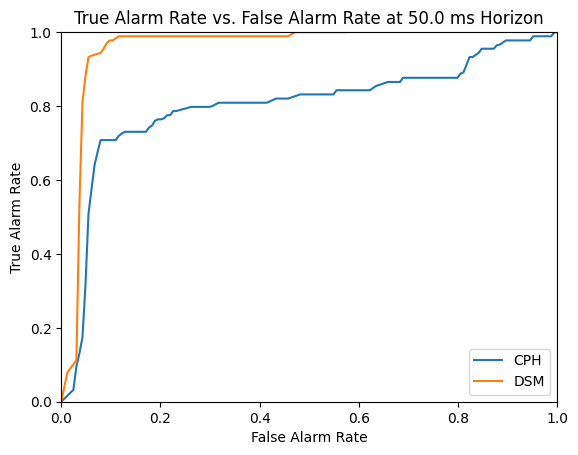

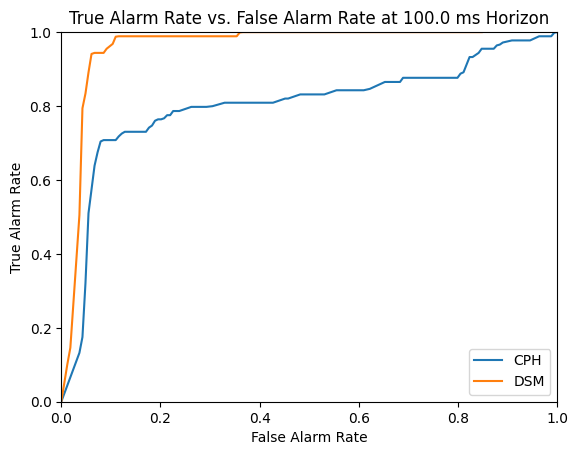

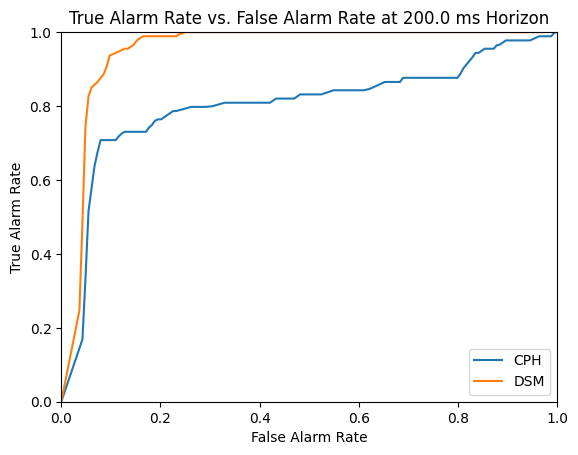

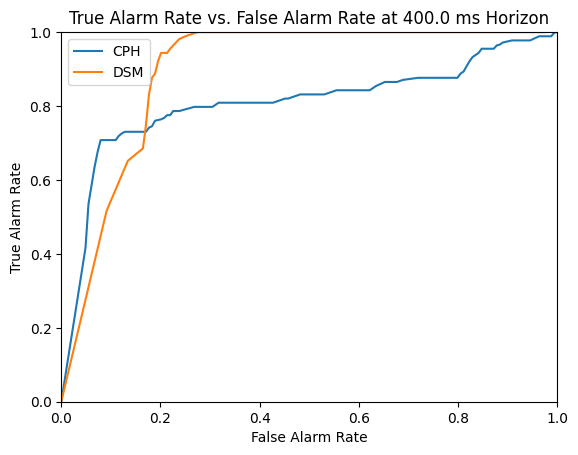

In [5]:
plot_TAR_vs_FAR(core_experiment_list, horizon=0.05)
plot_TAR_vs_FAR(core_experiment_list, horizon=0.1)
plot_TAR_vs_FAR(core_experiment_list, horizon=0.2)
plot_TAR_vs_FAR(core_experiment_list, horizon=0.4)

c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\plot_experiments.py:109: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0, 1])


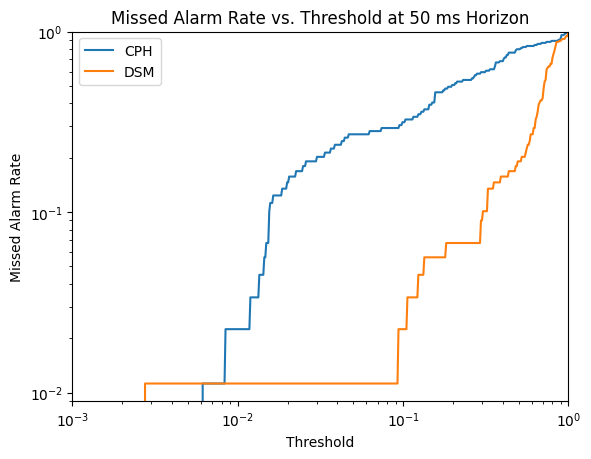

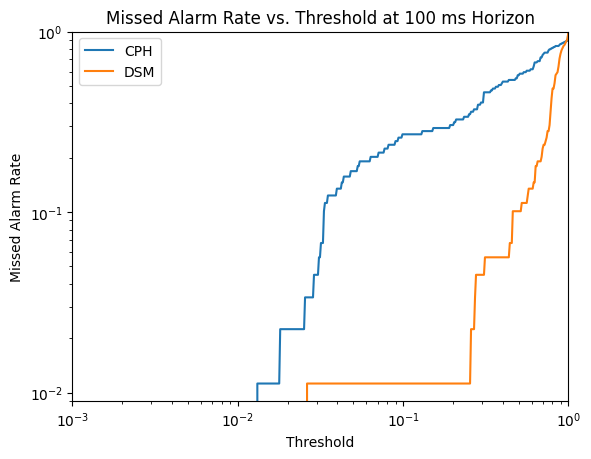

c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\plot_experiments.py:109: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0, 1])


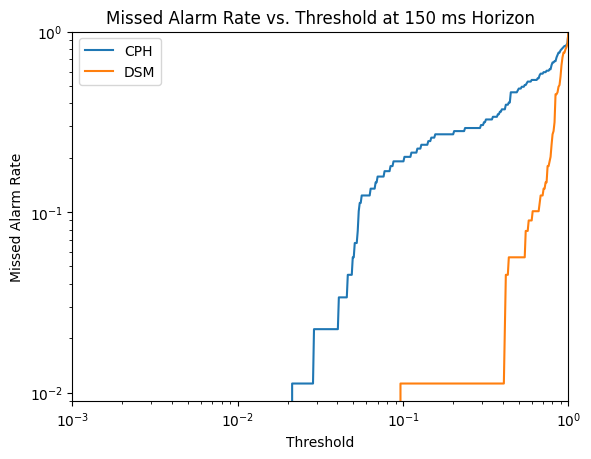

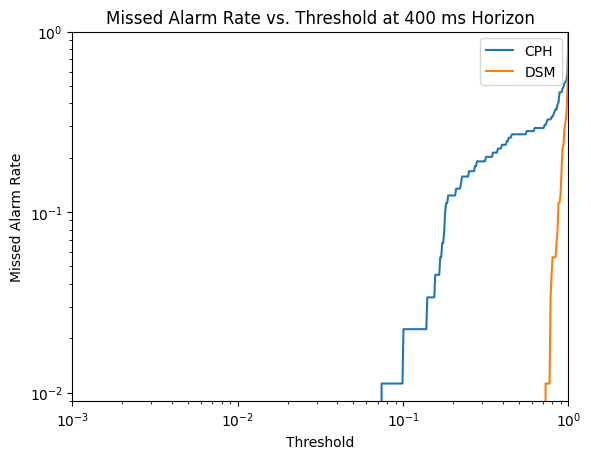

In [6]:
plot_missed_alarm_rate_vs_threshold(core_experiment_list, horizon=0.05)
plot_missed_alarm_rate_vs_threshold(core_experiment_list, horizon=0.1)
plot_missed_alarm_rate_vs_threshold(core_experiment_list, horizon=0.15)
plot_missed_alarm_rate_vs_threshold(core_experiment_list, horizon=0.4)

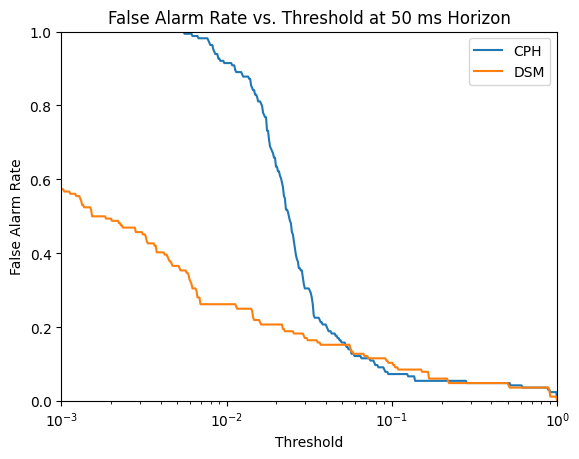

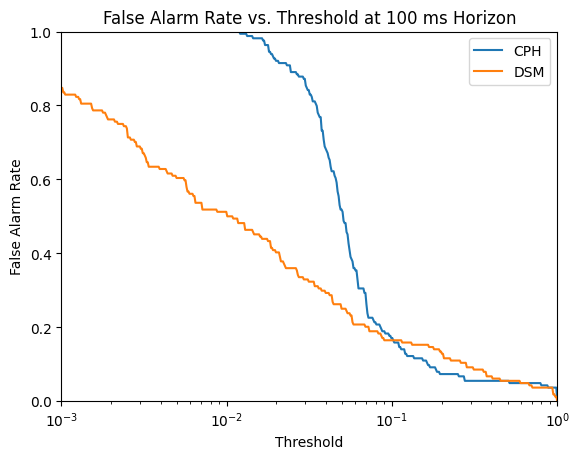

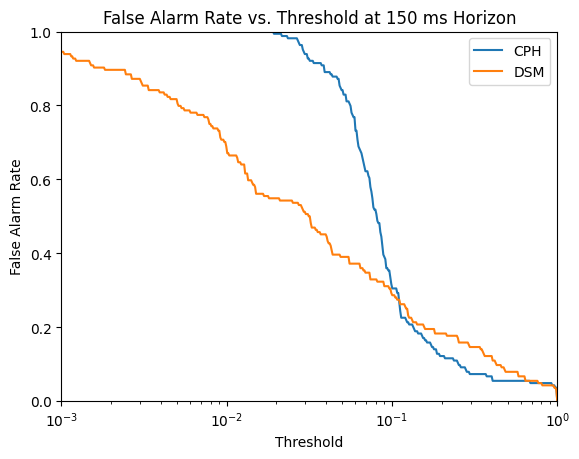

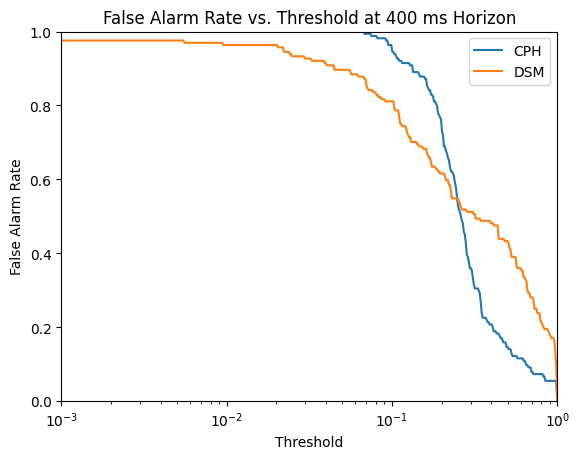

In [7]:
plot_FAR_vs_threshold(core_experiment_list, horizon=0.05)
plot_FAR_vs_threshold(core_experiment_list, horizon=0.1)
plot_FAR_vs_threshold(core_experiment_list, horizon=0.15)
plot_FAR_vs_threshold(core_experiment_list, horizon=0.4)

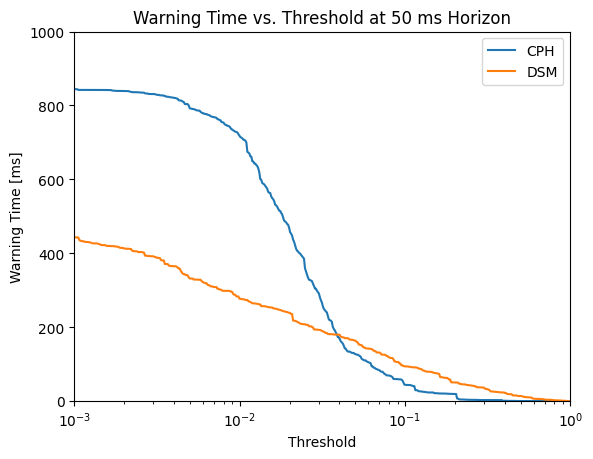

In [8]:
plot_warning_time_vs_threshold(core_experiment_list, 0.05)

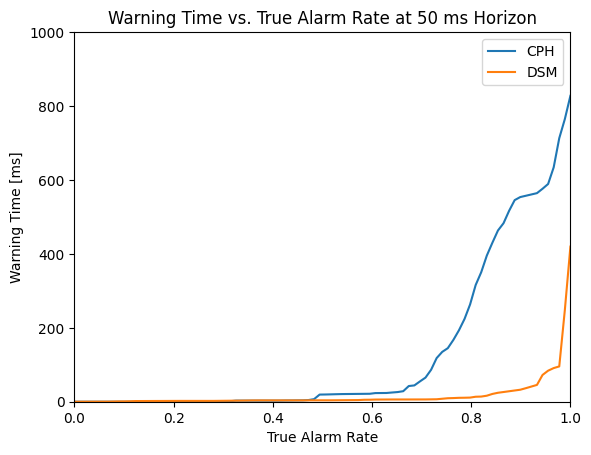

c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\plot_experiments.py:245: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([min_far, max_far])


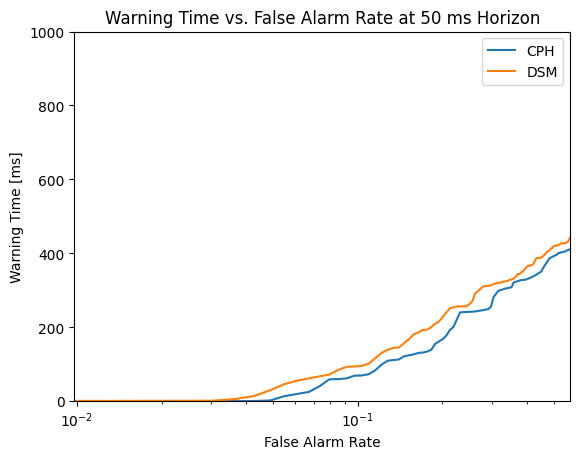

In [9]:
plot_warning_time_vs_TAR(core_experiment_list, 0.05)
plot_warning_time_vs_FAR(core_experiment_list, 0.05)

c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\Experiments.py:398: RuntimeWarning: invalid value encountered in divide
  threshold_precisions = np.sum(true_alarms, axis=0) / (np.sum(true_alarms, axis=0) + np.sum(false_alarms, axis=0))
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\zkeith\Documents\Risk-Aware Frameworks\di

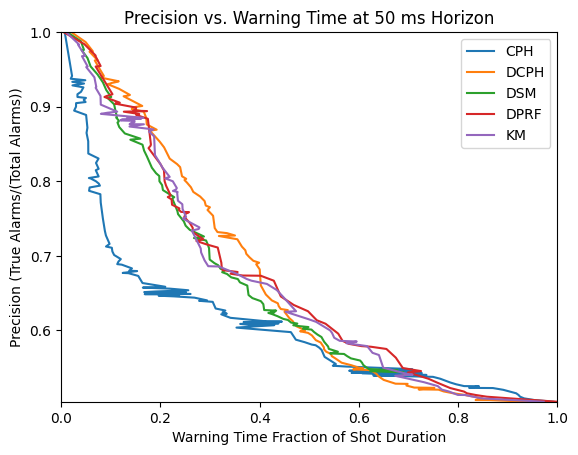

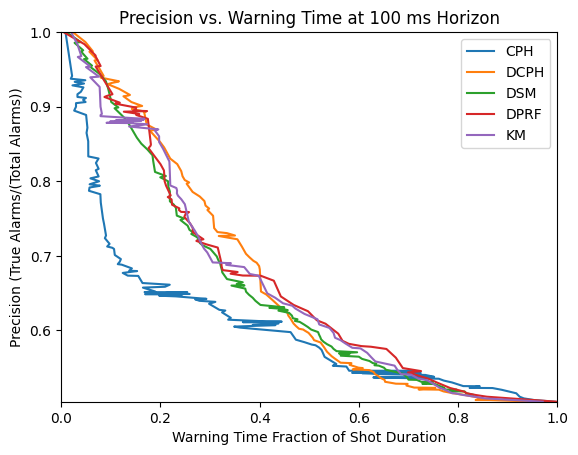

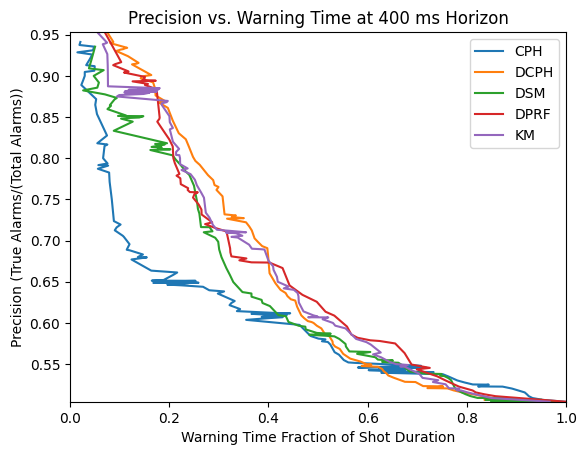

In [75]:
plot_warning_time_vs_precision(core_experiment_list, 0.05, scaled=True)
plot_warning_time_vs_precision(core_experiment_list, 0.1, scaled=True)
plot_warning_time_vs_precision(core_experiment_list, 0.4, scaled=True)

c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\plot_experiments.py:276: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([min_missed_alarm_rate, max_missed_alarm_rate])


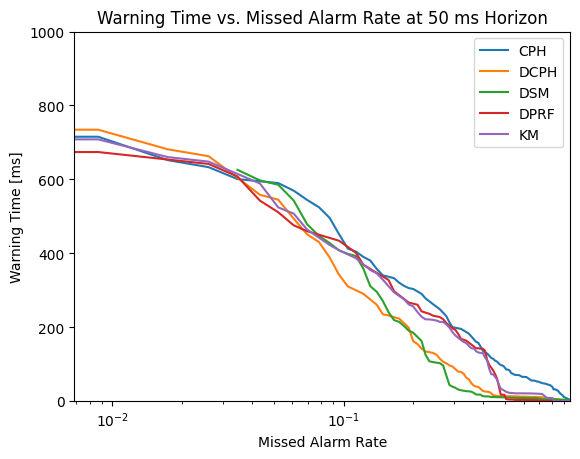

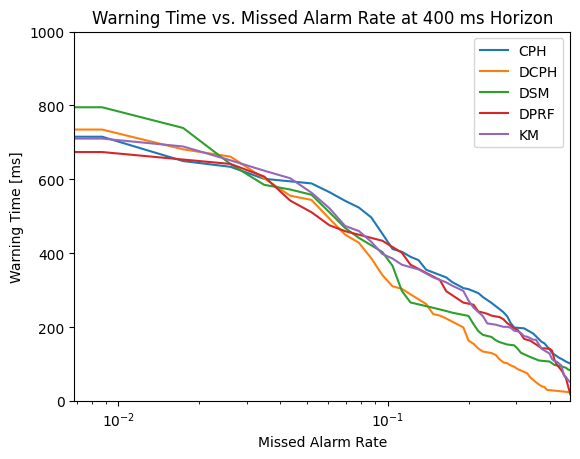

In [76]:
plot_warning_time_vs_missed_alarm_rate(core_experiment_list, 0.05)
plot_warning_time_vs_missed_alarm_rate(core_experiment_list, 0.4)

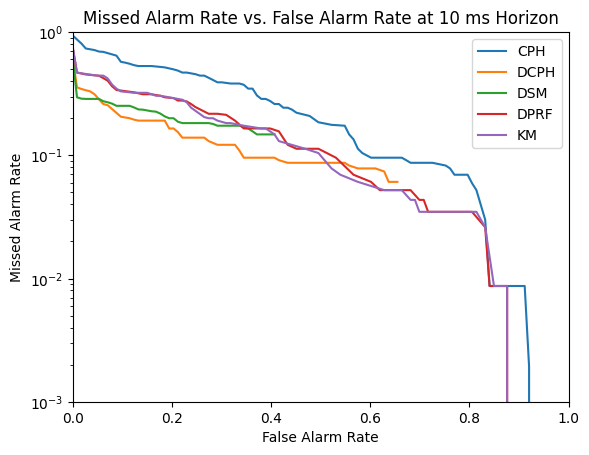

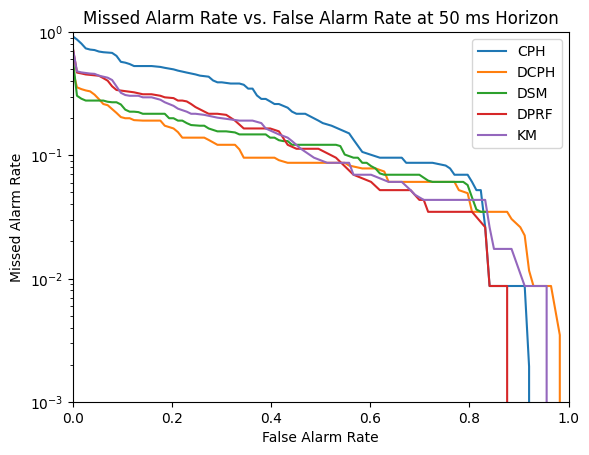

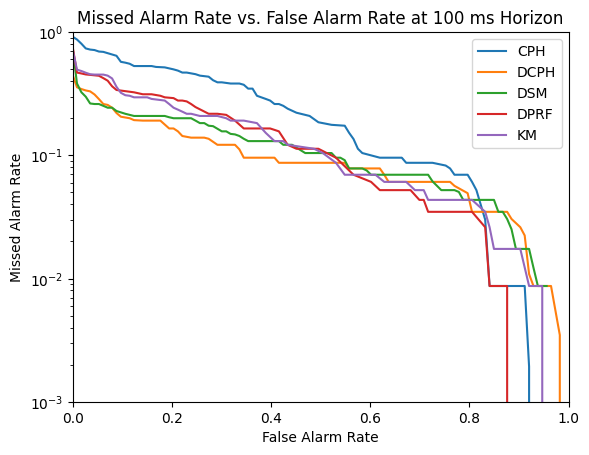

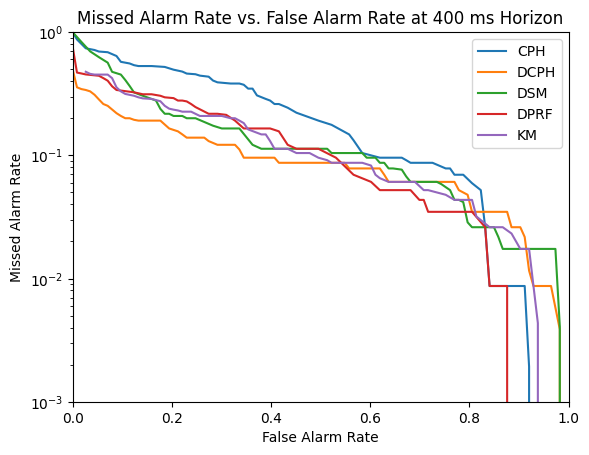

In [77]:
plot_missed_alarm_rate_vs_false_alarm_rate(core_experiment_list, 0.01)
plot_missed_alarm_rate_vs_false_alarm_rate(core_experiment_list, 0.05)
plot_missed_alarm_rate_vs_false_alarm_rate(core_experiment_list, 0.1)
plot_missed_alarm_rate_vs_false_alarm_rate(core_experiment_list, 0.4)

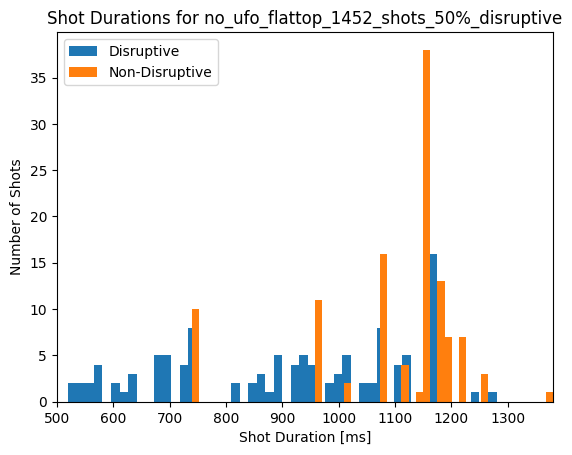

In [78]:
plot_disruptive_vs_non_disruptive_shot_durations(core_experiment_list[0])